<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classficiation-CNN/CNN_to_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries & Set Paths

In [12]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define dataset and model save paths (adjust as needed)
SPLIT_DATASET_PATH = '/content/drive/MyDrive/DSGP/Splitted_Dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/DSGP/multiclass_model.h5'

# Training parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

Create Data Generators

In [13]:
# Define the directories for train, validation, and test datasets
TRAIN_DIR = os.path.join(SPLIT_DATASET_PATH, 'train')
VAL_DIR = os.path.join(SPLIT_DATASET_PATH, 'val')
TEST_DIR = os.path.join(SPLIT_DATASET_PATH, 'test')

# Load raw training dataset to capture class names
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb'
)

# Capture class names from the raw training dataset
class_names = raw_train_dataset.class_names
print("Classes:", class_names)

# Load raw validation and test datasets
raw_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb'
)

raw_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    shuffle=False  # Keep order for evaluation
)

# Optimize the dataset pipeline with caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = raw_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = raw_val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = raw_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 25600 files belonging to 16 classes.
Classes: ['astrocitoma', 'carcinoma', 'ependimoma', 'ganglioglioma', 'germinoma', 'glioblastoma', 'granuloma', 'meduloblastoma', 'meningioma', 'neurocitoma', 'no_tumour', 'oligodendroglioma', 'papiloma', 'pituitary', 'schwannoma', 'tuberculoma']
Found 3200 files belonging to 16 classes.
Found 3200 files belonging to 16 classes.


Checking Data Loss

In [14]:
import hashlib
import os

def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

Build & Compile the CNN Model

In [15]:
num_classes = len(class_names)

model = models.Sequential([
    # If your images are not already normalized, use Rescaling; here we use it for safety.
    layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,171,024 (42.61 MB)

 Trainable params: 11,171,024 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Train & Save the Model

In [16]:
EPOCHS = 10  # Adjust as needed

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

# Save the trained model to Google Drive
model.save(MODEL_SAVE_PATH)
print("Model saved successfully at:", MODEL_SAVE_PATH)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 60ms/step - accuracy: 0.7478 - loss: 0.8582 - val_accuracy: 0.9881 - val_loss: 0.0400
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9878 - loss: 0.0458 - val_accuracy: 0.9906 - val_loss: 0.0358
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9940 - loss: 0.0229 - val_accuracy: 0.9928 - val_loss: 0.0239
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9976 - loss: 0.0087 - val_accuracy: 0.9869 - val_loss: 0.0388
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9901 - loss: 0.0331 - val_accuracy: 0.9956 - val_loss: 0.0224
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9787 - val_loss: 0.0932
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9948 - loss: 0.0237 - val_accuracy: 0.9969 - val_loss: 0.0177
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9981 - loss: 0.0068 - val_acc

Model saved successfully at: /content/drive/MyDrive/DSGP/multiclass_model.h5


Plot Training History

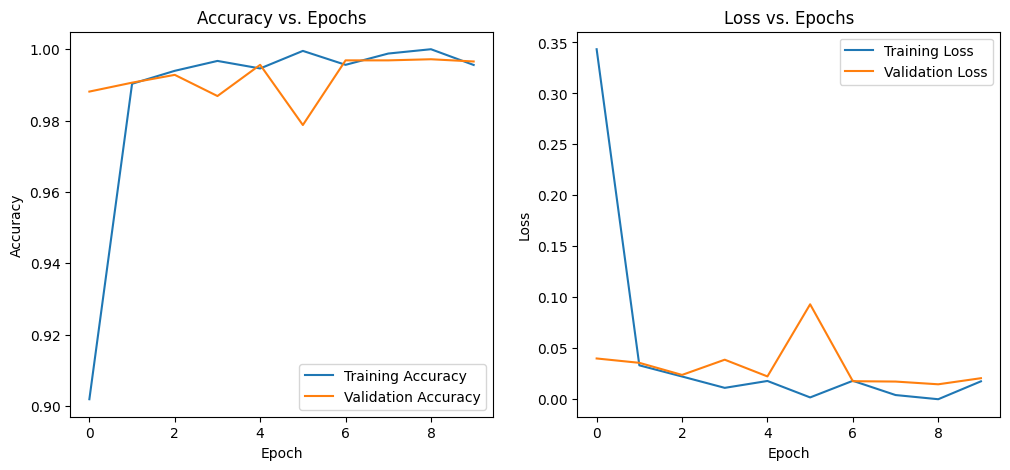

In [17]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Evaluate the Model

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
Classification Report:
                   precision    recall  f1-score   support

      astrocitoma       1.00      0.99      0.99       200
        carcinoma       1.00      1.00      1.00       200
       ependimoma       1.00      1.00      1.00       200
    ganglioglioma       1.00      1.00      1.00       200
        germinoma       1.00      1.00      1.00       200
     glioblastoma       1.00      1.00      1.00       200
        granuloma       1.00      1.00      1.00       200
   meduloblastoma       1.00      1.00      1.00       200
       meningioma       1.00      0.95      0.98       200
      neurocitoma       0.99      0.99      0.99       200
        no_tumour       0.96      1.00      0.98       200
oligodendroglioma       1.00      0.99      1.00       200
         papiloma       1.00      1.00      1.00       200
        pituitary       0.98      0.99      0.99       200
       schwannoma       1.00      1.00      1.00 

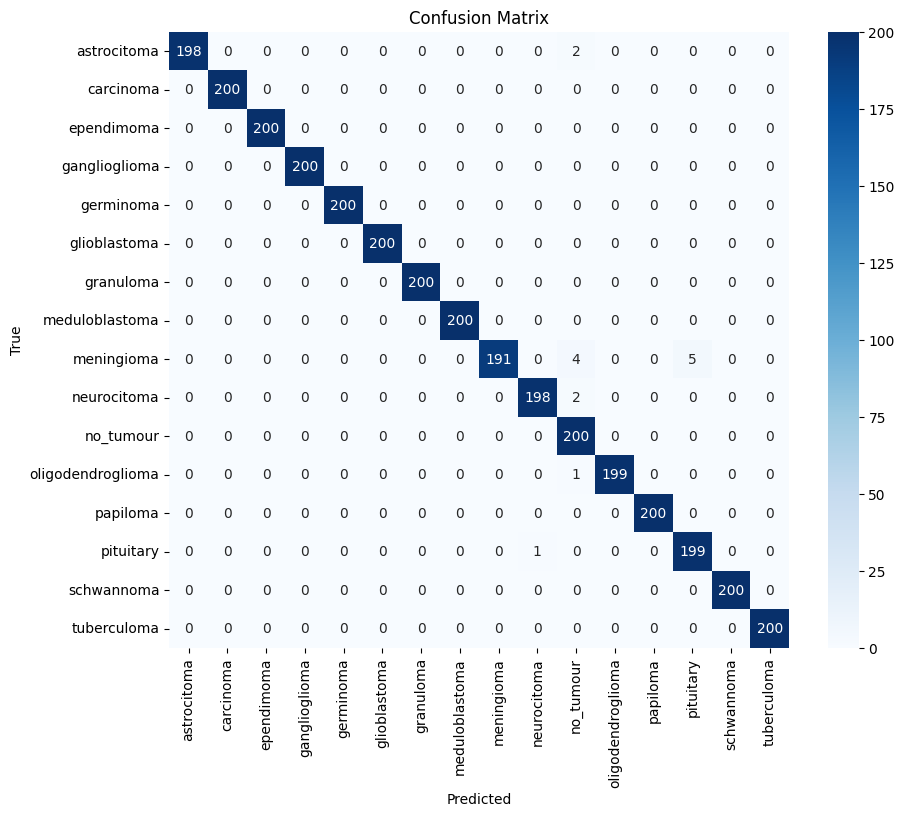

In [18]:
# Generate predictions for the test set
predictions = model.predict(test_dataset, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test dataset using tf.concat and tf.argmax
true_labels = tf.concat([y for x, y in test_dataset], axis=0).numpy()
true_labels = np.argmax(true_labels, axis=1)  # Convert one-hot to class indices

# Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Compute and plot the Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Flask Web Application Integration

In [19]:
from flask import Flask, request, jsonify
from PIL import Image
import io

app = Flask(__name__)
# Load the saved model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Use the same class labels (from the dataset)
class_labels = class_names

def preprocess_image(image, target_size):
    # Convert image to RGB if needed and resize
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image_array = np.array(image).astype("float32") / 255.0
    return np.expand_dims(image_array, axis=0)

@app.route("/", methods=["GET", "POST"])
def upload_predict():
    if request.method == "POST":
        if 'image' not in request.files:
            return jsonify({"error": "No image uploaded"}), 400
        image_file = request.files["image"].read()
        image = Image.open(io.BytesIO(image_file))
        processed_image = preprocess_image(image, target_size=IMG_SIZE)
        preds = model.predict(processed_image)
        predicted_index = np.argmax(preds, axis=1)[0]
        predicted_label = class_labels[predicted_index]
        return jsonify({"predicted_label": predicted_label})

    return '''
    <html>
      <body>
        <h1>Upload an Image for Prediction</h1>
        <form method="post" enctype="multipart/form-data">
          <input type="file" name="image" accept="image/*">
          <input type="submit" value="Predict">
        </form>
      </body>
    </html>
    '''

# Use flask_ngrok to run the app in Colab (if flask_ngrok is not installed, run: !pip install flask-ngrok)
try:
    from flask_ngrok import run_with_ngrok
    run_with_ngrok(app)
except ImportError:
    print("flask_ngrok not installed. Install it with: !pip install flask-ngrok")

app.run(host='0.0.0.0', port=5000, debug=True)

flask_ngrok not installed. Install it with: !pip install flask-ngrok
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
